In [63]:
from keras import models
from kb.extraction.extract_data_objects import extract_object_from_image, calculate_input_image, extract_size
from kb.generator.extract_class import remove_first, remove_last
from kb.models import dice_coeff, bce_dice_loss
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
plt.rcParams["figure.figsize"] = (10, 10)

### Model for position detection

In [64]:
positionDetectionModels = [
    models.load_model(
        "models/oben.hdf5",
        custom_objects = {
            'bce_dice_loss': bce_dice_loss,
            'dice_coeff': dice_coeff
        }
    ),
    models.load_model(
        "models/seite.hdf5",
        custom_objects = {
            'bce_dice_loss': bce_dice_loss,
            'dice_coeff': dice_coeff
        }
    ),
    models.load_model(
        "models/unter.hdf5",
        custom_objects = {
            'bce_dice_loss': bce_dice_loss,
            'dice_coeff': dice_coeff
        }
    ),
]

### Model for classification

In [65]:
classificationModels = [
    models.load_model("models/classification_oben.hdf5"),
    models.load_model("models/classification_seite.hdf5"),
    models.load_model("models/classification_unter.hdf5"),
]

with open('models/classification_oben_labels.hdf5') as f:
    oben_classes = [line.rstrip() for line in f]
with open('models/classification_seite_labels.hdf5') as f:
    seite_classes = [line.rstrip() for line in f]
with open('models/classification_unter_labels.hdf5') as f:
    unter_classes = [line.rstrip() for line in f]

classificationClasses = [
    oben_classes,
    seite_classes,
    unter_classes,
]

### Functions and const

In [66]:
size = (256, 256)

def normalize_image(img):
    return np.array(img/256)

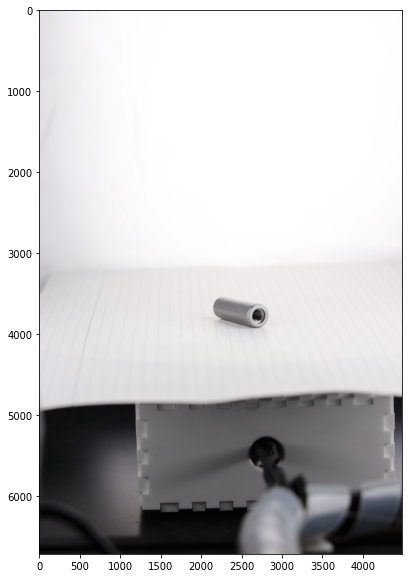

In [67]:
imagePath = "data/original/Kegelstift/DIN7978-A/10x32/unten/4J9A5739.JPG"
image = imread(imagePath)
plt.imshow(image)

### Position Detection Result

In [68]:
resizedImage = normalize_image(cv.resize(image, size))
masks = []
for positionDetectionModel in positionDetectionModels:
    result = positionDetectionModel.predict(np.array([resizedImage]))
    masks.append(result)

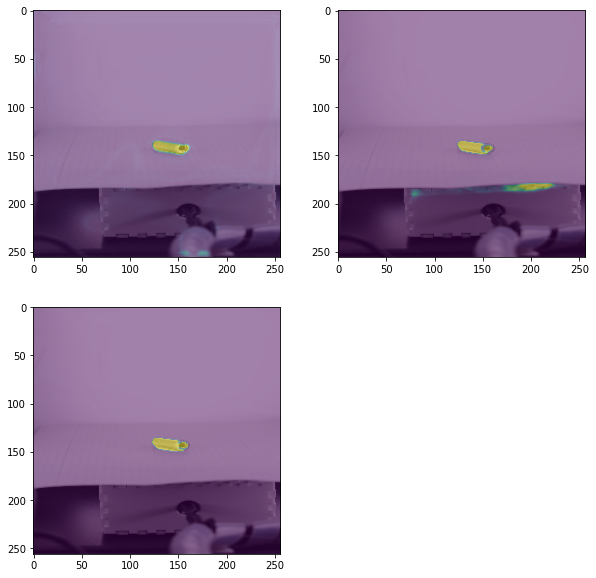

In [69]:
for mask, i in zip(masks, range(len(masks))):
    plt.subplot(2, 2, i+1)
    plt.imshow(resizedImage)
    plt.imshow(mask[0], alpha=0.5)

### Object Extraction

In [70]:
objects = []
for positionDetectionModel in positionDetectionModels:
    try:
        object = extract_object_from_image(positionDetectionModel, image, (256, 256))
        objects.append(object)
    except Exception as exception:
        print(exception)

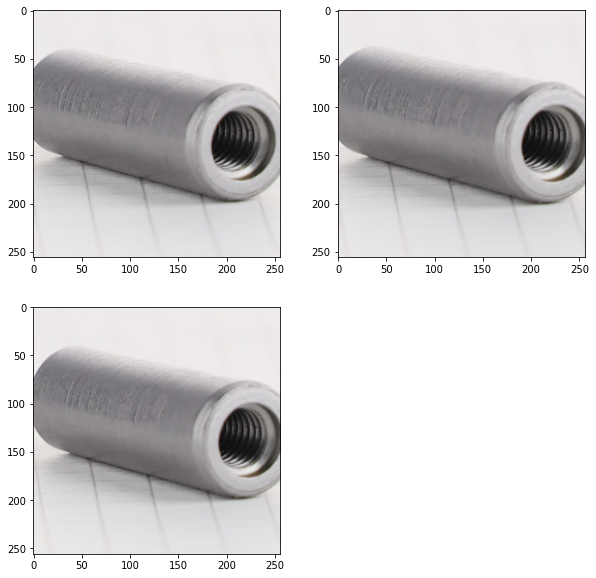

In [71]:
for object, i in zip(objects, range(len(objects))):
    plt.subplot(2, 2, i+1)
    plt.imshow(object)

### Classification

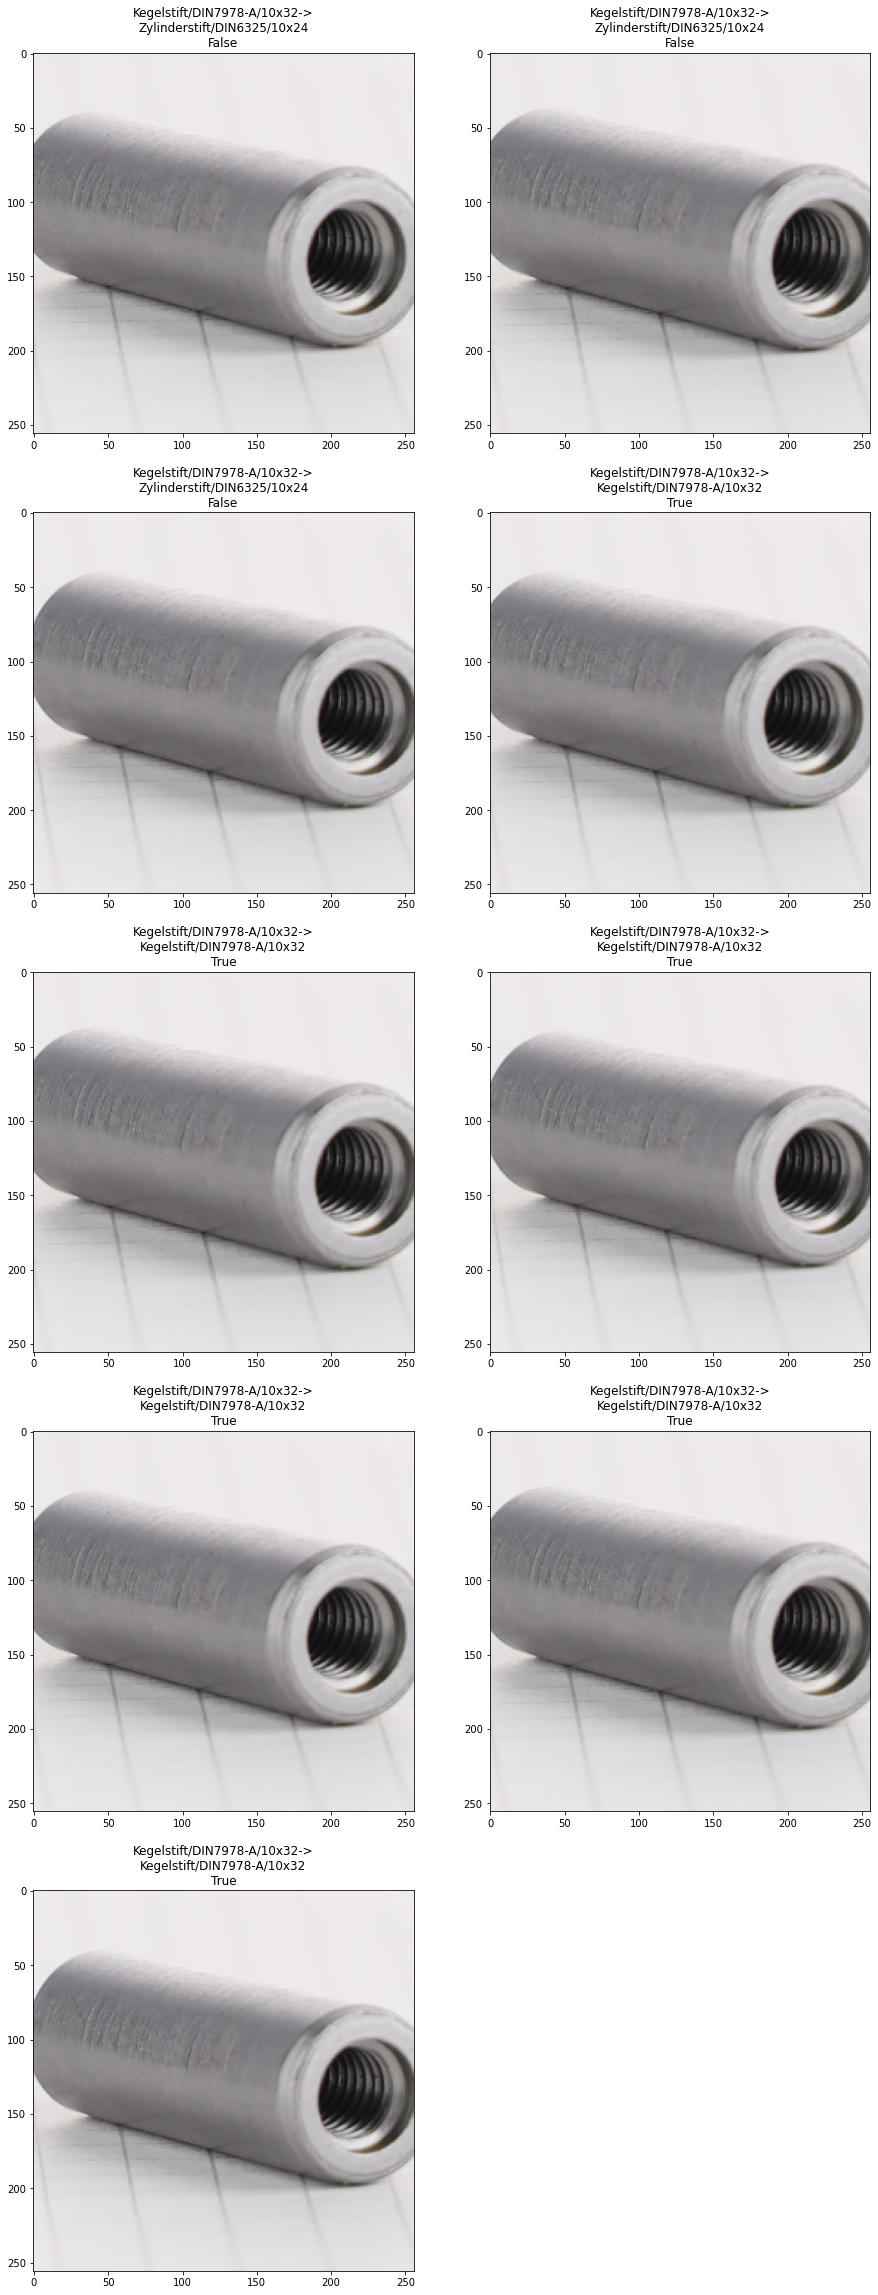

In [72]:
plt.rcParams["figure.figsize"] = (15, 100)
def evaluation(image, model, classes, info, i):
    predicted_label = model.predict(np.array([image]))
    plt.subplot(12,2, i)
    plt.imshow(image)
    origin = remove_first(remove_first(remove_last(remove_last(info))))
    target = remove_first(classes[np.argmax(predicted_label[0])])
    plt.title(origin + '->\n' + target + '\n' + str(origin == target))

n = 0
for model, classes in zip(classificationModels, classificationClasses):
    for index, img in zip(range(len(objects)), objects):
        n+=1
        # plt.subplots_adjust(hspace = 0.8, wspace=0.8)
        evaluation(img, model, classes, imagePath, n)